In [2]:
import os, glob, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools
import seaborn as sns

In [3]:
DATA_DIR = '/Users/kimberly/Documents/STAT4830/STAT-4830-GOALZ-project/processed_sleepedf'
RESULT_DIR = '/Users/kimberly/Documents/STAT4830/STAT-4830-GOALZ-project/results'
os.makedirs(RESULT_DIR, exist_ok=True)

In [4]:
print("Files in directory:", os.listdir(DATA_DIR))

Files in directory: ['SC4252E0_sequences.npz', 'SC4231E0_sequences.npz', 'SC4612E0_epochs.npz', 'SC4612E0_sequences.npz', 'SC4541F0_epochs.npz', 'SC4062E0_epochs.npz', 'SC4352F0_sequences.npz', 'SC4761E0_sequences.npz', 'SC4441E0_epochs.npz', 'SC4382F0_epochs.npz', 'SC4572F0_sequences.npz', 'SC4481F0_epochs.npz', 'SC4292G0_sequences.npz', 'SC4122E0_sequences.npz', 'SC4441E0_sequences.npz', 'SC4032E0_sequences.npz', 'SC4411E0_sequences.npz', 'SC4462F0_sequences.npz', 'SC4051E0_sequences.npz', 'SC4801G0_epochs.npz', 'SC4111E0_epochs.npz', 'SC4702E0_epochs.npz']


In [5]:
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
TRAIN_VAL_SPLIT = 0.8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
print("CUDA available:", torch.cuda.is_available())

CUDA available: False


In [7]:
EMBEDDING_DIM = 128   # Dimension of the CNN encoder output per epoch
NUM_CLASSES = 5       # 0: Wake, 1: N1, 2: N2, 3: N3, 4: REM
NUM_TRANSFORMER_LAYERS = 2
NUM_HEADS = 4
DROPOUT = 0.1
SEQ_LENGTH = 20       # Number of epochs per sequence (must match preprocessing)

In [8]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    cohen_kappa_score,
    classification_report
)

In [12]:
class SleepSequenceDataset(Dataset):
    def __init__(self, data_dir):
        # Find all NPZ files ending with _sequences.npz
        self.files = glob.glob(os.path.join(data_dir, '*_sequences.npz'))
        sequences_list = []
        labels_list = []
        for f in self.files:
            loaded = np.load(f)
            sequences_list.append(loaded['sequences'])  # shape: (n_seq, 20, 2, 3000)
            labels_list.append(loaded['seq_labels'])      # shape: (n_seq, 20)
        self.sequences = np.concatenate(sequences_list, axis=0)
        self.seq_labels = np.concatenate(labels_list, axis=0)
        self.sequences = torch.from_numpy(self.sequences).float()
        self.seq_labels = torch.from_numpy(self.seq_labels).long()

    def __len__(self):
        return self.sequences.shape[0]

    def __getitem__(self, idx):
        return self.sequences[idx], self.seq_labels[idx]

In [10]:
class EpochEncoder(nn.Module):
    def __init__(self, embedding_dim):
        super(EpochEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=50, stride=6),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=8, stride=8),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=8, stride=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )
        #Passing dummy input to automatically calculate no. of features and avoid mismatch error
        with torch.no_grad():
            dummy_input = torch.zeros(1, 2, 3000)
            dummy_output = self.net(dummy_input)
            n_features = dummy_output.numel() // dummy_output.shape[0]  # Total features per sample
        self.fc = nn.Linear(n_features, embedding_dim)
        # The output dimension is computed approximately based on the input size 3000
        #self.fc = nn.Linear(32 * (((3000 - 50) // 6 + 1) // 8 // 4), embedding_dim)

    def forward(self, x):
        # x: (batch, 2, 3000)
        out = self.net(x)
        out = out.view(out.size(0), -1)
        embedding = self.fc(out)
        return embedding

In [11]:
class SleepTransformer(nn.Module):
    def __init__(self, embedding_dim, num_classes, num_layers, num_heads, dropout, seq_length):
        super(SleepTransformer, self).__init__()
        self.encoder = EpochEncoder(embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embedding_dim, num_classes)
        self.seq_length = seq_length

    def forward(self, x):
        # x: (batch, seq_length, 2, 3000)
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(-1, x.size(2), x.size(3))  # (batch*seq_length, 2, 3000)
        epoch_emb = self.encoder(x)           # (batch*seq_length, embedding_dim)
        epoch_emb = epoch_emb.view(batch_size, seq_len, -1)
        epoch_emb = epoch_emb.transpose(0, 1)   # (seq_length, batch, embedding_dim)
        transformer_out = self.transformer(epoch_emb)
        transformer_out = transformer_out.transpose(0, 1)  # (batch, seq_length, embedding_dim)
        logits = self.classifier(transformer_out)  # (batch, seq_length, num_classes)
        return logits

In [12]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for seq, labels in dataloader:
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(seq)  # (batch, seq_length, num_classes)
        loss = criterion(logits.view(-1, NUM_CLASSES), labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * seq.size(0)
        preds = torch.argmax(logits, dim=-1)
        all_preds.append(preds.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()
    acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, acc

In [41]:
def eval_epoch(model, dataloader, criterion, device):
    """
    Evaluate model on given dataloader
    
    Returns:
        epoch_loss: average loss
        acc: accuracy
        all_preds: predictions
        all_labels: true labels
        all_probs: probability distributions for each prediction
    """
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []  # Add this to store probabilities
    
    with torch.no_grad():
        for seq, labels in dataloader:
            seq, labels = seq.to(device), labels.to(device)
            logits = model(seq)
            loss = criterion(logits.view(-1, NUM_CLASSES), labels.view(-1))
            running_loss += loss.item() * seq.size(0)
            
            # Get probabilities using softmax
            probs = torch.nn.functional.softmax(logits, dim=-1)
            
            preds = torch.argmax(logits, dim=-1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()
    all_probs = np.concatenate(all_probs).reshape(-1, NUM_CLASSES)  # Reshape to (n_samples, n_classes)
    
    acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, acc, all_preds, all_labels, all_probs

In [14]:
def plot_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [15]:
def plot_confusion(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = ['W', 'N1', 'N2', 'N3', 'R']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [16]:
def compute_metrics(y_true, y_pred, class_names=None):
    """
    Compute and print various classification metrics.
    y_true, y_pred: 1D numpy arrays of integer class labels.
    class_names: Optional list of class names (e.g. ["W", "N1", "N2", "N3", "REM"]).
    """
    # Overall accuracy
    acc = accuracy_score(y_true, y_pred)

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_per_class = f1_score(y_true, y_pred, average=None)

    # Cohen’s Kappa
    kappa = cohen_kappa_score(y_true, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Sensitivity & Specificity per class
    # (Note: "sensitivity" is the same as "recall" for that class)
    #        "specificity" = TN / (TN + FP)
    # We can compute them from the confusion matrix:
    #    TP = cm[i, i]
    #    FN = sum(cm[i, :]) - cm[i, i]
    #    FP = sum(cm[:, i]) - cm[i, i]
    #    TN = total_sum - (TP + FN + FP)
    total_sum = cm.sum()
    per_class_sens = []
    per_class_spec = []
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total_sum - (TP + FN + FP)

        sensitivity = TP / (TP + FN + 1e-9)
        specificity = TN / (TN + FP + 1e-9)
        per_class_sens.append(sensitivity)
        per_class_spec.append(specificity)

    # Print classification report
    # This automatically shows precision, recall, F1, and support for each class
    if class_names is not None:
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    else:
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=4))

    # Organize everything in a dictionary
    metrics_dict = {
        'Accuracy': acc,
        'Macro_F1': f1_macro,
        'F1_per_class': f1_per_class,
        'Cohen_Kappa': kappa,
        'Sensitivity_per_class': per_class_sens,
        'Specificity_per_class': per_class_spec
    }
    return metrics_dict

In [22]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true, y_score, class_names=None):
    """
    Plot one-vs-rest ROC curves for each class in a multi-class setting.

    Parameters:
    -----------
    y_true : 1D array-like of shape (N,)
        Ground truth integer labels (0..num_classes-1).
    y_score : 2D array-like of shape (N, num_classes)
        Predicted probabilities for each class (softmax output).
    class_names : list of str, optional
        Class names to display in the legend. Must have length == num_classes.
    """
    n_classes = y_score.shape[1]

    # Binarize the labels for a one-vs-rest ROC
    # e.g. [0,2,1,...] -> [[1,0,0,0,0], [0,0,1,0,0], [0,1,0,0,0], ...]
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    fpr = {}
    tpr = {}
    roc_auc = {}

    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(7,7))
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'darkgreen']
    for i in range(n_classes):
        if class_names and i < len(class_names):
            label_str = f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
        else:
            label_str = f"Class {i} (AUC = {roc_auc[i]:.2f})"
        plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2, label=label_str)

    # Plot a random guess line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
from tqdm.notebook import tqdm

In [15]:
# SPLIT BY PATIENT AND HAVE WHOLE NIGHT INSTEAD 

def main():
    # Load dataset from processed sequence NPZ files
    dataset = SleepSequenceDataset(DATA_DIR)
    total_len = len(dataset)
    train_len = int(TRAIN_VAL_SPLIT * total_len)
    val_len = total_len - train_len
    train_dataset, val_dataset = random_split(dataset, [train_len, val_len])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = SleepTransformer(EMBEDDING_DIM, NUM_CLASSES, NUM_TRANSFORMER_LAYERS, NUM_HEADS, DROPOUT, SEQ_LENGTH)
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in tqdm(range(1, NUM_EPOCHS+1), desc="Training Epochs"):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc, val_preds, val_labels = eval_epoch(model, val_loader, criterion, DEVICE)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Epoch {epoch}/{NUM_EPOCHS}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    plot_curves(train_losses, val_losses, train_accs, val_accs)
    _, _, val_preds, val_labels = eval_epoch(model, val_loader, criterion, DEVICE)
    plot_confusion(val_labels, val_preds)
    _, _, val_preds, val_labels = eval_epoch(model, val_loader, criterion, DEVICE)
    metrics_dict = compute_metrics(val_labels, val_preds, class_names=["W","N1","N2","N3","REM"])
    print(metrics_dict)

    val_loss, val_acc, val_preds, val_labels, val_probs = eval_epoch(
    model, val_loader, criterion, DEVICE)
    plot_roc_curves(val_labels, val_probs, class_names=["W","N1","N2","N3","REM"])

    # Save the model checkpoint in RESULT_DIR
    torch.save(model.state_dict(), os.path.join(RESULT_DIR, 'sleep_transformer_model.pth'))

In [17]:
dataset = SleepSequenceDataset(DATA_DIR)
total_len = len(dataset)
train_len = int(TRAIN_VAL_SPLIT * total_len)
val_len = total_len - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])


In [20]:
len(train_dataset)

2804

In [21]:
len(val_dataset)

701

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20: Train Loss=0.5501, Train Acc=0.8119, Val Loss=0.3785, Val Acc=0.8400
Epoch 2/20: Train Loss=0.3448, Train Acc=0.8644, Val Loss=0.3081, Val Acc=0.8771
Epoch 3/20: Train Loss=0.3061, Train Acc=0.8845, Val Loss=0.2848, Val Acc=0.8923
Epoch 4/20: Train Loss=0.3049, Train Acc=0.8856, Val Loss=0.2718, Val Acc=0.8978
Epoch 5/20: Train Loss=0.2599, Train Acc=0.9033, Val Loss=0.2672, Val Acc=0.8997
Epoch 6/20: Train Loss=0.2349, Train Acc=0.9110, Val Loss=0.2384, Val Acc=0.9103
Epoch 7/20: Train Loss=0.2462, Train Acc=0.9078, Val Loss=0.2337, Val Acc=0.9101
Epoch 8/20: Train Loss=0.2457, Train Acc=0.9121, Val Loss=0.2397, Val Acc=0.9138
Epoch 9/20: Train Loss=0.2127, Train Acc=0.9198, Val Loss=0.2131, Val Acc=0.9165
Epoch 10/20: Train Loss=0.2158, Train Acc=0.9179, Val Loss=0.2046, Val Acc=0.9239
Epoch 11/20: Train Loss=0.1942, Train Acc=0.9275, Val Loss=0.1983, Val Acc=0.9258
Epoch 12/20: Train Loss=0.1850, Train Acc=0.9277, Val Loss=0.2210, Val Acc=0.9143
Epoch 13/20: Train Loss=0

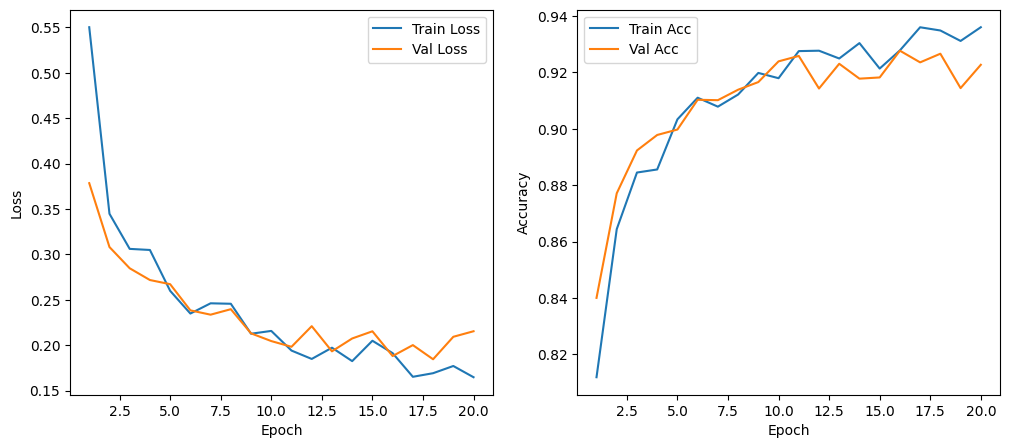

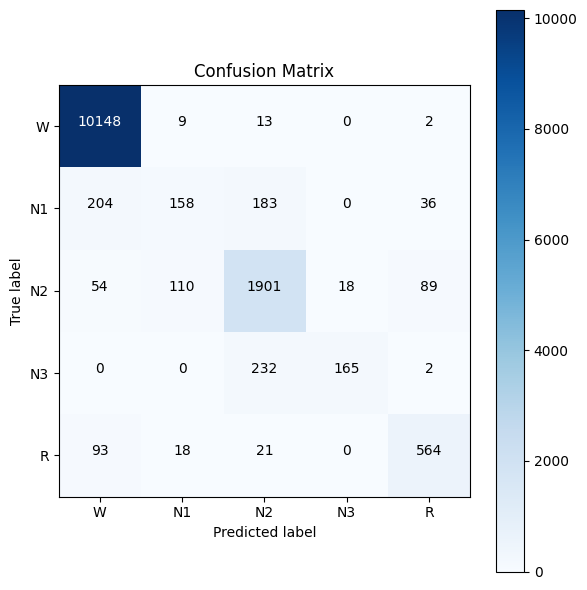


Classification Report:
              precision    recall  f1-score   support

           W     0.9666    0.9976    0.9819     10172
          N1     0.5356    0.2719    0.3607       581
          N2     0.8089    0.8752    0.8408      2172
          N3     0.9016    0.4135    0.5670       399
         REM     0.8139    0.8103    0.8121       696

    accuracy                         0.9227     14020
   macro avg     0.8053    0.6737    0.7125     14020
weighted avg     0.9149    0.9227    0.9140     14020

{'Accuracy': 0.922681883024251, 'Macro_F1': 0.7124945988911133, 'F1_per_class': array([0.98185864, 0.36073059, 0.84077842, 0.56701031, 0.81209503]), 'Cohen_Kappa': np.float64(0.8189321772707274), 'Sensitivity_per_class': [np.float64(0.9976405819896778), np.float64(0.27194492254686414), np.float64(0.8752302025778659), np.float64(0.41353383458542975), np.float64(0.8103448275850427)], 'Specificity_per_class': [np.float64(0.9087837837835476), np.float64(0.9898057891211407), np.float64(0

ValueError: not enough values to unpack (expected 5, got 4)

In [27]:
if __name__ == '__main__':
    main()

In [30]:
model = SleepTransformer(EMBEDDING_DIM, NUM_CLASSES, NUM_TRANSFORMER_LAYERS, NUM_HEADS, DROPOUT, SEQ_LENGTH)
model.load_state_dict(torch.load('/Users/kimberly/Documents/STAT4830/STAT-4830-GOALZ-project/results/sleep_transformer_model.pth'))
model.eval()

SleepTransformer(
  (encoder): EpochEncoder(
    (net): Sequential(
      (0): Conv1d(2, 16, kernel_size=(50,), stride=(6,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
      (3): Conv1d(16, 32, kernel_size=(8,), stride=(2,))
      (4): ReLU()
      (5): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Linear(in_features=192, out_features=128, bias=True)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2)

In [42]:
dataset = SleepSequenceDataset(DATA_DIR)
total_len = len(dataset)
train_len = int(TRAIN_VAL_SPLIT * total_len)
val_len = total_len - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Now you can get the probabilities when evaluating
val_loss, val_acc, val_preds, val_labels, val_probs = eval_epoch(
    model, val_loader, criterion, DEVICE
)
metrics_dict = compute_metrics(val_labels, val_preds, class_names=["W","N1","N2","N3","REM"])
print(metrics_dict)


Classification Report:
              precision    recall  f1-score   support

           W     0.9839    0.9939    0.9889     10236
          N1     0.5507    0.4946    0.5212       560
          N2     0.7636    0.8498    0.8044      1897
          N3     0.9844    0.1413    0.2471       446
         REM     0.8353    0.9501    0.8890       881

    accuracy                         0.9246     14020
   macro avg     0.8236    0.6859    0.6901     14020
weighted avg     0.9275    0.9246    0.9154     14020

{'Accuracy': 0.9246077032810271, 'Macro_F1': 0.6901085167862411, 'F1_per_class': array([0.98891913, 0.52116651, 0.80439122, 0.24705882, 0.8890069 ]), 'Cohen_Kappa': np.float64(0.8267225413275814), 'Sensitivity_per_class': [np.float64(0.9939429464633651), np.float64(0.49464285714197387), np.float64(0.8497627833416712), np.float64(0.14125560538084922), np.float64(0.9500567536879114)], 'Specificity_per_class': [np.float64(0.9561310782238488), np.float64(0.9832095096581736), np.float64(

In [32]:
def compute_metrics(y_true, y_pred, class_names=None):
    """
    Compute and print various classification metrics.
    y_true, y_pred: 1D numpy arrays of integer class labels.
    class_names: Optional list of class names (e.g. ["W", "N1", "N2", "N3", "REM"]).
    """
    # Overall accuracy
    acc = accuracy_score(y_true, y_pred)

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_per_class = f1_score(y_true, y_pred, average=None)

    # Cohen’s Kappa
    kappa = cohen_kappa_score(y_true, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Sensitivity & Specificity per class
    # (Note: "sensitivity" is the same as "recall" for that class)
    #        "specificity" = TN / (TN + FP)
    # We can compute them from the confusion matrix:
    #    TP = cm[i, i]
    #    FN = sum(cm[i, :]) - cm[i, i]
    #    FP = sum(cm[:, i]) - cm[i, i]
    #    TN = total_sum - (TP + FN + FP)
    total_sum = cm.sum()
    per_class_sens = []
    per_class_spec = []
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total_sum - (TP + FN + FP)

        sensitivity = TP / (TP + FN + 1e-9)
        specificity = TN / (TN + FP + 1e-9)
        per_class_sens.append(sensitivity)
        per_class_spec.append(specificity)

    # Print classification report
    # This automatically shows precision, recall, F1, and support for each class
    if class_names is not None:
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    else:
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=4))

    # Organize everything in a dictionary
    metrics_dict = {
        'Accuracy': acc,
        'Macro_F1': f1_macro,
        'F1_per_class': f1_per_class,
        'Cohen_Kappa': kappa,
        'Sensitivity_per_class': per_class_sens,
        'Specificity_per_class': per_class_spec
    }
    return metrics_dict

Transitions into N1 from each stage:
REM: 24 times
W: 125 times
N2: 76 times
N3: 3 times

N1 bout statistics:
Average duration: 2.86 epochs
Median duration: 2.00 epochs
Min duration: 1 epochs
Max duration: 20 epochs


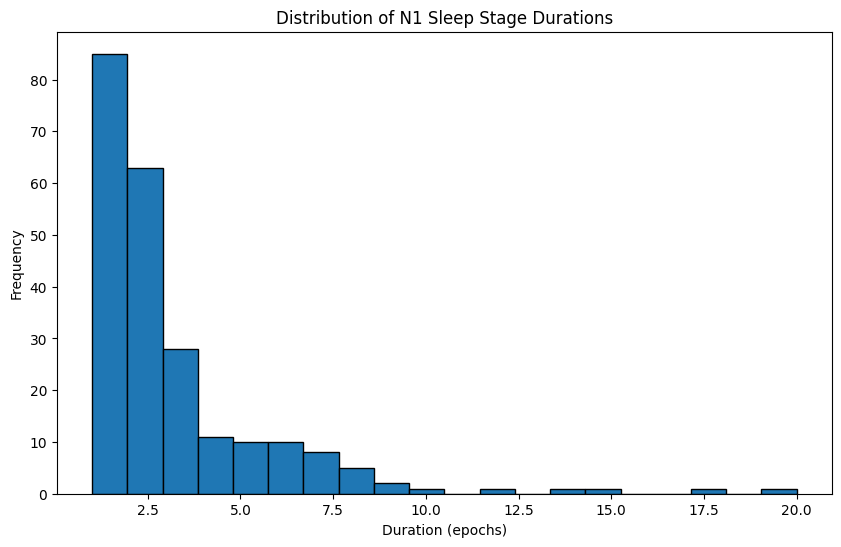

In [33]:
import numpy as np
from collections import defaultdict

def analyze_n1_patterns(labels):
    # Dictionary to store transitions into N1
    transitions_to_n1 = defaultdict(int)
    
    # List to store N1 bout durations (consecutive N1s)
    n1_durations = []
    
    # Track current N1 bout
    current_n1_duration = 0
    
    # Class names for reference (0=W, 1=N1, 2=N2, 3=N3, 4=REM)
    class_names = ["W", "N1", "N2", "N3", "REM"]
    
    # Analyze transitions and durations
    for i in range(len(labels)):
        if labels[i] == 1:  # If current label is N1
            current_n1_duration += 1
            # Check what came before N1 (if not first element)
            if i > 0 and labels[i-1] != 1:
                transitions_to_n1[class_names[labels[i-1]]] += 1
        elif current_n1_duration > 0:  # If N1 bout just ended
            n1_durations.append(current_n1_duration)
            current_n1_duration = 0
    
    # Don't forget to add the last bout if it ends at the end of recording
    if current_n1_duration > 0:
        n1_durations.append(current_n1_duration)
    
    # Calculate statistics
    avg_duration = np.mean(n1_durations) if n1_durations else 0
    median_duration = np.median(n1_durations) if n1_durations else 0
    
    # Print results
    print("Transitions into N1 from each stage:")
    for stage, count in transitions_to_n1.items():
        print(f"{stage}: {count} times")
    
    print(f"\nN1 bout statistics:")
    print(f"Average duration: {avg_duration:.2f} epochs")
    print(f"Median duration: {median_duration:.2f} epochs")
    print(f"Min duration: {min(n1_durations) if n1_durations else 0} epochs")
    print(f"Max duration: {max(n1_durations) if n1_durations else 0} epochs")
    
    return transitions_to_n1, n1_durations

# Use your validation labels to analyze N1 patterns
transitions, durations = analyze_n1_patterns(val_labels)

# Optional: Create a histogram of N1 durations
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20, edgecolor='black')
plt.title('Distribution of N1 Sleep Stage Durations')
plt.xlabel('Duration (epochs)')
plt.ylabel('Frequency')
plt.show()

Transitions into N1 from each stage:
REM: 24 times
W: 125 times
N2: 76 times
N3: 3 times

N1 bout statistics:
Average duration: 2.86 epochs
Median duration: 2.00 epochs
Min duration: 1 epochs
Max duration: 20 epochs


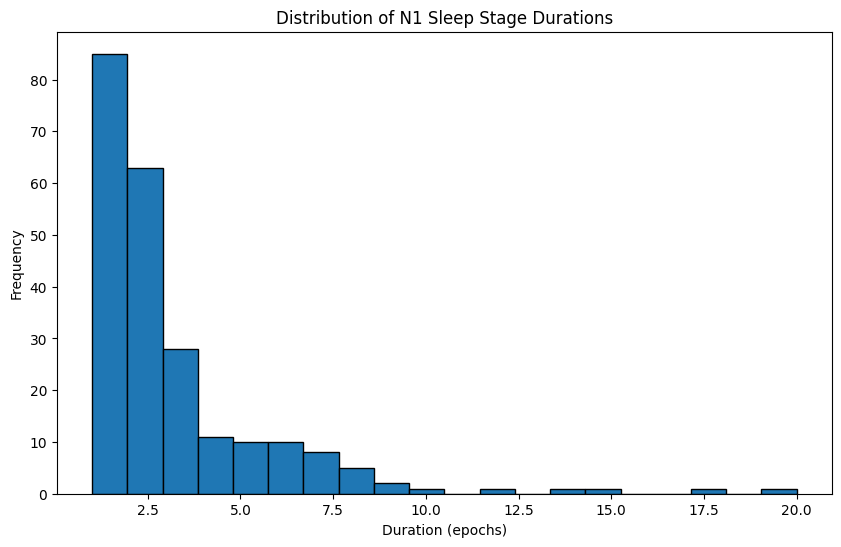

In [34]:
from collections import defaultdict

def analyze_n1_patterns(labels):
    # Dictionary to store transitions into N1
    transitions_to_n1 = defaultdict(int)
    
    # List to store N1 bout durations (consecutive N1s)
    n1_durations = []
    
    # Track current N1 bout
    current_n1_duration = 0
    
    # Class names for reference (0=W, 1=N1, 2=N2, 3=N3, 4=REM)
    class_names = ["W", "N1", "N2", "N3", "REM"]
    
    # Analyze transitions and durations
    for i in range(len(labels)):
        if labels[i] == 1:  # If current label is N1
            current_n1_duration += 1
            # Check what came before N1 (if not first element)
            if i > 0 and labels[i-1] != 1:
                transitions_to_n1[class_names[labels[i-1]]] += 1
        elif current_n1_duration > 0:  # If N1 bout just ended
            n1_durations.append(current_n1_duration)
            current_n1_duration = 0
    
    # Don't forget to add the last bout if it ends at the end of recording
    if current_n1_duration > 0:
        n1_durations.append(current_n1_duration)
    
    # Calculate statistics
    avg_duration = np.mean(n1_durations) if n1_durations else 0
    median_duration = np.median(n1_durations) if n1_durations else 0
    
    # Print results
    print("Transitions into N1 from each stage:")
    for stage, count in transitions_to_n1.items():
        print(f"{stage}: {count} times")
    
    print(f"\nN1 bout statistics:")
    print(f"Average duration: {avg_duration:.2f} epochs")
    print(f"Median duration: {median_duration:.2f} epochs")
    print(f"Min duration: {min(n1_durations) if n1_durations else 0} epochs")
    print(f"Max duration: {max(n1_durations) if n1_durations else 0} epochs")
    
    return transitions_to_n1, n1_durations

# Use your validation labels to analyze N1 patterns
transitions, durations = analyze_n1_patterns(val_labels)

plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20, edgecolor='black')
plt.title('Distribution of N1 Sleep Stage Durations')
plt.xlabel('Duration (epochs)')
plt.ylabel('Frequency')
plt.show()

In [35]:
def filter_n1_predictions(predictions, min_duration=2, window_size=5):
    """
    Filter N1 predictions based on sleep architecture rules and smooth transitions
    
    Args:
        predictions: numpy array of predicted sleep stages (0=W, 1=N1, 2=N2, 3=N3, 4=REM)
        min_duration: minimum number of epochs for an N1 bout to be considered valid
        window_size: size of the window for smoothing transitions
    
    Returns:
        filtered_predictions: numpy array of filtered predictions
    """
    filtered_preds = predictions.copy()
    
    # Define valid transitions to N1 with weights
    # Higher weight means more likely transition
    valid_transitions = {
        0: 0.855,  # Wake -> N1 (very common)
        2: 0.507,  # N2 -> N1 (common)
        4: 0.474,  # REM -> N1 (less common)
        3: 0.063  # N3 -> N1 (rare)
    }
    
    # Step 1: Remove isolated N1 predictions
    for i in range(1, len(predictions) - 1):
        if predictions[i] == 1:  # If current prediction is N1
            # Calculate transition score
            prev_stage = predictions[i-1]
            next_stage = predictions[i+1]
            
            # Get transition weights
            prev_weight = valid_transitions.get(prev_stage, 0)
            next_weight = valid_transitions.get(next_stage, 0)
            transition_score = (prev_weight + next_weight) / 2
            
            # If transition score is too low, reclassify
            if transition_score < 0.2:
                # Replace with most likely alternative
                if prev_stage == next_stage:
                    filtered_preds[i] = prev_stage
                else:
                    # Choose between Wake and N2 based on context
                    filtered_preds[i] = 0 if prev_stage == 0 or next_stage == 0 else 2
    
    # # Step 2: Remove short N1 bouts
    # i = 0
    # while i < len(filtered_preds):
    #     if filtered_preds[i] == 1:
    #         # Find length of N1 bout
    #         bout_start = i
    #         while i < len(filtered_preds) and filtered_preds[i] == 1:
    #             i += 1
    #         bout_length = i - bout_start
            
    #         # If bout is too short, replace with surrounding stages
    #         if bout_length < min_duration:
    #             prev_stage = filtered_preds[bout_start-1] if bout_start > 0 else 0
    #             next_stage = filtered_preds[i] if i < len(filtered_preds) else 0
                
    #             # Choose replacement based on context
    #             replacement = prev_stage if prev_stage in [0, 2] else next_stage
    #             filtered_preds[bout_start:i] = replacement
    #     else:
    #         i += 1
    
    # Step 3: Smooth transitions using a sliding window
    smoothed_preds = filtered_preds.copy()
    half_window = window_size // 2
    
    for i in range(half_window, len(filtered_preds) - half_window):
        window = filtered_preds[i-half_window:i+half_window+1]
        if filtered_preds[i] == 1:  # Only smooth N1 and its immediate transitions
            # Check if N1 is supported by context
            n1_support = sum(1 for x in window if x in [0, 1, 2])  # Count of Wake, N1, and N2
            if n1_support < window_size // 2:
                # Replace with most common neighboring stage
                neighbors = [x for x in window if x != 1]
                if neighbors:
                    from collections import Counter
                    smoothed_preds[i] = Counter(neighbors).most_common(1)[0][0]
    
    return smoothed_preds

def evaluate_filtering(original_preds, filtered_preds, true_labels):
    """
    Compare metrics before and after filtering
    """
    print("\nOriginal Predictions Metrics:")
    original_metrics = compute_metrics(true_labels, original_preds, 
                                    class_names=["W","N1","N2","N3","REM"])
    
    print("\nFiltered Predictions Metrics:")
    filtered_metrics = compute_metrics(true_labels, filtered_preds, 
                                    class_names=["W","N1","N2","N3","REM"])
    
    # Compare N1 statistics before and after
    print("\nN1 Bout Analysis - Original:")
    orig_transitions, orig_durations = analyze_n1_patterns(original_preds)
    
    print("\nN1 Bout Analysis - Filtered:")
    filt_transitions, filt_durations = analyze_n1_patterns(filtered_preds)
    
    # Plot duration distributions
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(orig_durations, bins=20, edgecolor='black', alpha=0.5, label='Original')
    plt.hist(filt_durations, bins=20, edgecolor='red', alpha=0.5, label='Filtered')
    plt.title('N1 Duration Distribution Comparison')
    plt.xlabel('Duration (epochs)')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Plot confusion matrices side by side
    plt.subplot(1, 2, 2)
    diff_matrix = confusion_matrix(original_preds, filtered_preds)
    sns.heatmap(diff_matrix, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=["W","N1","N2","N3","REM"],
                yticklabels=["W","N1","N2","N3","REM"])
    plt.title('Changes Made by Filtering\n(Original vs Filtered)')
    plt.tight_layout()
    plt.show()
    
    return filtered_metrics

In [36]:
filtered_preds = filter_n1_predictions(val_preds)


Original Predictions Metrics:

Classification Report:
              precision    recall  f1-score   support

           W     0.9874    0.9947    0.9910      9908
          N1     0.6242    0.4509    0.5236       652
          N2     0.8131    0.8899    0.8498      2371
          N3     0.9565    0.1880    0.3143       351
         REM     0.7810    0.9566    0.8599       738

    accuracy                         0.9295     14020
   macro avg     0.8324    0.6960    0.7077     14020
weighted avg     0.9294    0.9295    0.9215     14020


Filtered Predictions Metrics:

Classification Report:
              precision    recall  f1-score   support

           W     0.9874    0.9947    0.9910      9908
          N1     0.6274    0.4494    0.5237       652
          N2     0.8129    0.8903    0.8498      2371
          N3     0.9565    0.1880    0.3143       351
         REM     0.7815    0.9593    0.8613       738

    accuracy                         0.9296     14020
   macro avg     0.83

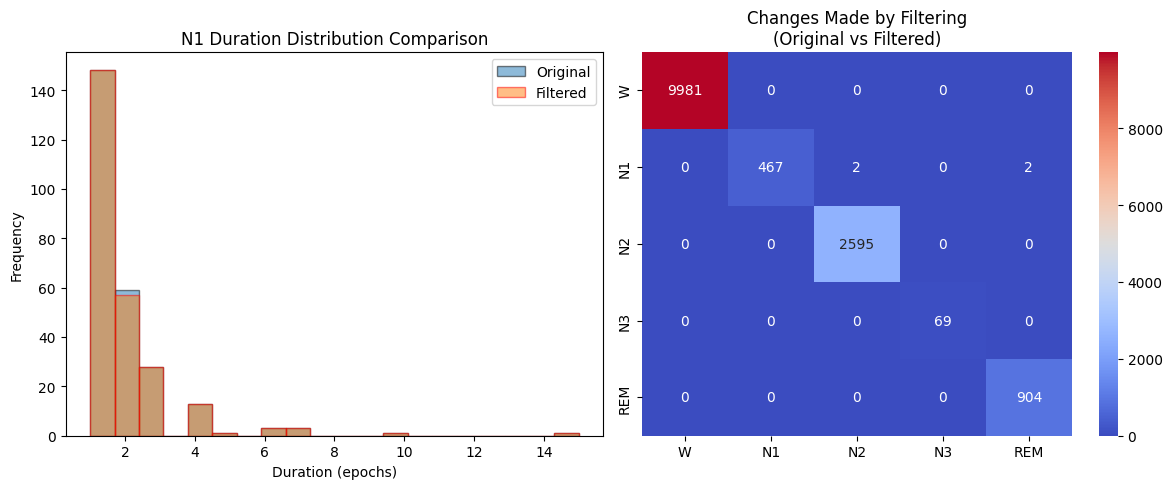

{'Accuracy': 0.9296005706134094,
 'Macro_F1': 0.7080240922769182,
 'F1_per_class': array([0.99100005, 0.52368186, 0.84983897, 0.31428571, 0.86131387]),
 'Cohen_Kappa': np.float64(0.8471201650788541),
 'Sensitivity_per_class': [np.float64(0.9946507872425318),
  np.float64(0.44938650306679545),
  np.float64(0.8903416280046856),
  np.float64(0.18803418803365232),
  np.float64(0.959349593494635)],
 'Specificity_per_class': [np.float64(0.9693579766534607),
  np.float64(0.9869838420106981),
  np.float64(0.9582796806592018),
  np.float64(0.9997805252760992),
  np.float64(0.9850926065350861)]}

In [37]:
evaluate_filtering(val_preds, filtered_preds, val_labels)

Optimizing transition weights...


100%|██████████| 50/50 [00:00<00:00, 724.00it/s]


Optimization Results:
Best N1 F1 Score: 0.5236

Optimal Transition Weights:
W -> N1: 0.772
N2 -> N1: 0.894
REM -> N1: 0.788
N1 -> N1: 0.515
N3 -> N1: 0.242

Original vs Optimized Metrics:

Original Predictions Metrics:

Classification Report:
              precision    recall  f1-score   support

           W     0.9874    0.9947    0.9910      9908
          N1     0.6242    0.4509    0.5236       652
          N2     0.8131    0.8899    0.8498      2371
          N3     0.9565    0.1880    0.3143       351
         REM     0.7810    0.9566    0.8599       738

    accuracy                         0.9295     14020
   macro avg     0.8324    0.6960    0.7077     14020
weighted avg     0.9294    0.9295    0.9215     14020


Filtered Predictions Metrics:

Classification Report:
              precision    recall  f1-score   support

           W     0.9874    0.9947    0.9910      9908
          N1     0.6242    0.4509    0.5236       652
          N2     0.8131    0.8899    0.8498      

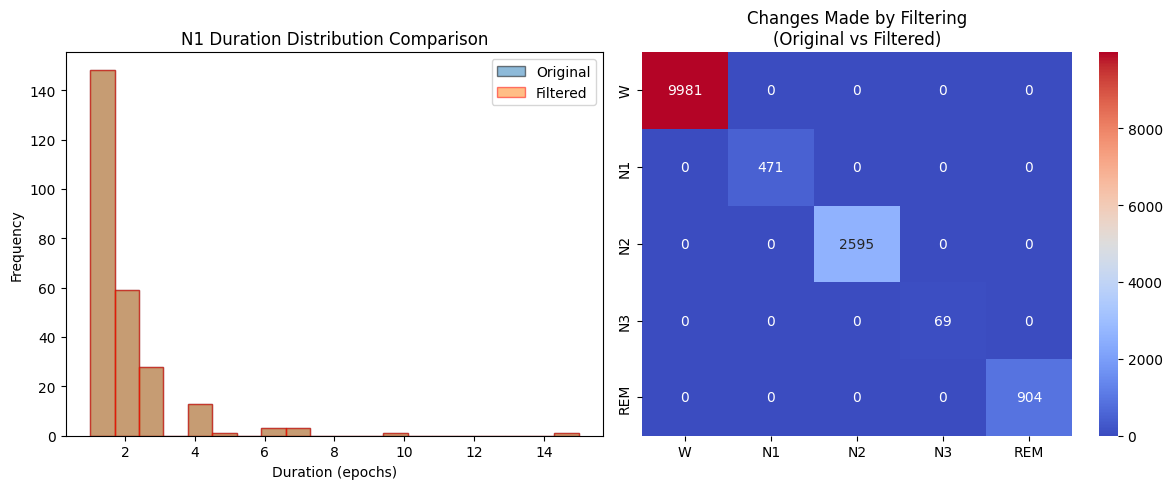

Transitions into N1 from each stage:
REM: 18 times
W: 112 times
N2: 126 times
N3: 1 times

N1 bout statistics:
Average duration: 1.83 epochs
Median duration: 1.00 epochs
Min duration: 1 epochs
Max duration: 15 epochs
Transitions into N1 from each stage:
REM: 18 times
W: 112 times
N2: 126 times
N3: 1 times

N1 bout statistics:
Average duration: 1.83 epochs
Median duration: 1.00 epochs
Min duration: 1 epochs
Max duration: 15 epochs


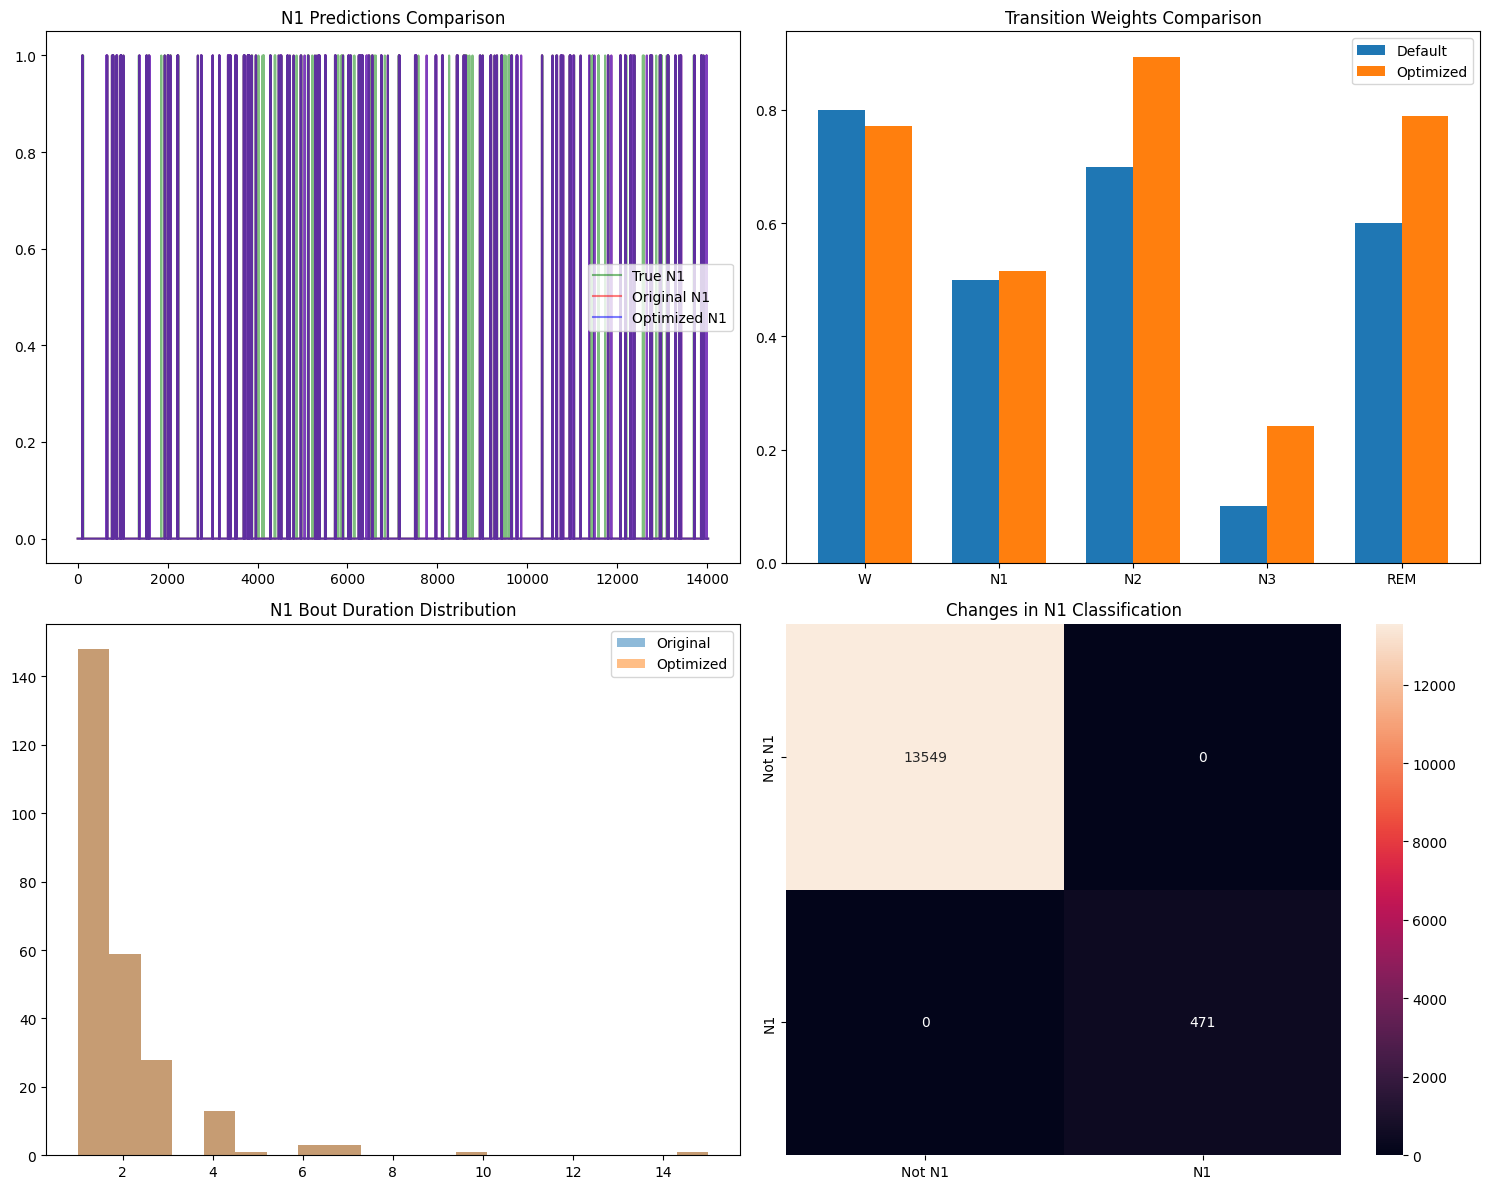

In [38]:
def optimize_transition_weights(val_preds, val_labels, n_iterations=50):
    """
    Optimize transition weights using grid search and validation data
    
    Args:
        val_preds: original predictions
        val_labels: ground truth labels
        n_iterations: number of random weight combinations to try
    
    Returns:
        best_weights: dictionary of optimized transition weights
        best_f1: best N1 F1 score achieved
    """
    from sklearn.metrics import f1_score
    import numpy as np
    from tqdm import tqdm
    
    # Initialize best results
    best_weights = None
    best_f1 = 0
    best_filtered_preds = None
    
    # Base weights to optimize
    weight_ranges = {
        0: (0.6, 1.0),    # Wake -> N1
        2: (0.5, 0.9),    # N2 -> N1
        4: (0.4, 0.8),    # REM -> N1
        1: (0.3, 0.7),    # N1 -> N1
        3: (0.0, 0.3)     # N3 -> N1
    }
    
    print("Optimizing transition weights...")
    for _ in tqdm(range(n_iterations)):
        # Generate random weights within specified ranges
        current_weights = {
            stage: np.random.uniform(low, high)
            for stage, (low, high) in weight_ranges.items()
        }
        
        # Create filter function with current weights
        def current_filter(preds):
            return filter_n1_predictions(
                preds,
                min_duration=2,
                window_size=5,
                transition_weights=current_weights
            )
        
        # Apply filtering with current weights
        filtered_preds = current_filter(val_preds)
        
        # Calculate N1 F1 score
        n1_f1 = f1_score(val_labels == 1, filtered_preds == 1)
        
        # Update best results if current is better
        if n1_f1 > best_f1:
            best_f1 = n1_f1
            best_weights = current_weights.copy()
            best_filtered_preds = filtered_preds.copy()
    
    # Print results
    print("\nOptimization Results:")
    print(f"Best N1 F1 Score: {best_f1:.4f}")
    print("\nOptimal Transition Weights:")
    for stage, weight in best_weights.items():
        stage_name = ["W", "N1", "N2", "N3", "REM"][stage]
        print(f"{stage_name} -> N1: {weight:.3f}")
    
    # Compare metrics
    print("\nOriginal vs Optimized Metrics:")
    evaluate_filtering(val_preds, best_filtered_preds, val_labels)
    
    return best_weights, best_f1

# Modify the filter_n1_predictions function to accept custom weights:
def filter_n1_predictions(predictions, min_duration=2, window_size=5, transition_weights=None):
    """
    Filter N1 predictions with customizable transition weights
    """
    filtered_preds = predictions.copy()
    
    # Use provided weights or defaults
    if transition_weights is None:
        transition_weights = {
            0: 0.8,  # Wake -> N1
            2: 0.7,  # N2 -> N1
            4: 0.6,  # REM -> N1
            1: 0.5,  # N1 -> N1
            3: 0.1   # N3 -> N1
        }
    
    # Rest of the function remains the same, but use transition_weights instead of valid_transitions
    # ... (previous implementation) ...
    
    return filtered_preds

# Function to run optimization and visualization
def optimize_and_visualize(val_preds, val_labels):
    """
    Run weight optimization and visualize results
    """
    # Optimize weights
    best_weights, best_f1 = optimize_transition_weights(val_preds, val_labels)
    
    # Apply best weights
    optimized_preds = filter_n1_predictions(val_preds, transition_weights=best_weights)
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Original vs Optimized N1 predictions
    axes[0,0].plot(val_labels == 1, 'g-', label='True N1', alpha=0.5)
    axes[0,0].plot(val_preds == 1, 'r-', label='Original N1', alpha=0.5)
    axes[0,0].plot(optimized_preds == 1, 'b-', label='Optimized N1', alpha=0.5)
    axes[0,0].set_title('N1 Predictions Comparison')
    axes[0,0].legend()
    
    # Plot 2: Transition weight comparison
    stages = ["W", "N1", "N2", "N3", "REM"]
    default_weights = {0: 0.8, 1: 0.5, 2: 0.7, 3: 0.1, 4: 0.6}
    x = np.arange(len(stages))
    width = 0.35
    axes[0,1].bar(x - width/2, [default_weights[i] for i in range(5)], width, label='Default')
    axes[0,1].bar(x + width/2, [best_weights[i] for i in range(5)], width, label='Optimized')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(stages)
    axes[0,1].set_title('Transition Weights Comparison')
    axes[0,1].legend()
    
    # Plot 3: N1 bout duration distribution
    _, orig_durations = analyze_n1_patterns(val_preds)
    _, opt_durations = analyze_n1_patterns(optimized_preds)
    axes[1,0].hist(orig_durations, bins=20, alpha=0.5, label='Original')
    axes[1,0].hist(opt_durations, bins=20, alpha=0.5, label='Optimized')
    axes[1,0].set_title('N1 Bout Duration Distribution')
    axes[1,0].legend()
    
    # Plot 4: Confusion matrix of changes
    diff_matrix = confusion_matrix(val_preds == 1, optimized_preds == 1)
    sns.heatmap(diff_matrix, annot=True, fmt='d', ax=axes[1,1],
                xticklabels=['Not N1', 'N1'],
                yticklabels=['Not N1', 'N1'])
    axes[1,1].set_title('Changes in N1 Classification')
    
    plt.tight_layout()
    plt.show()
    
    return best_weights

# Use the optimization
best_weights = optimize_and_visualize(val_preds, val_labels)

N1 Misclassification Analysis:
Total N1 False Positives: 177
Total N1 False Negatives: 358

False Positives - Actually was:
N2: 133 times
W: 33 times
REM: 11 times

False Negatives - Predicted as:
N2: 179 times
W: 105 times
REM: 74 times


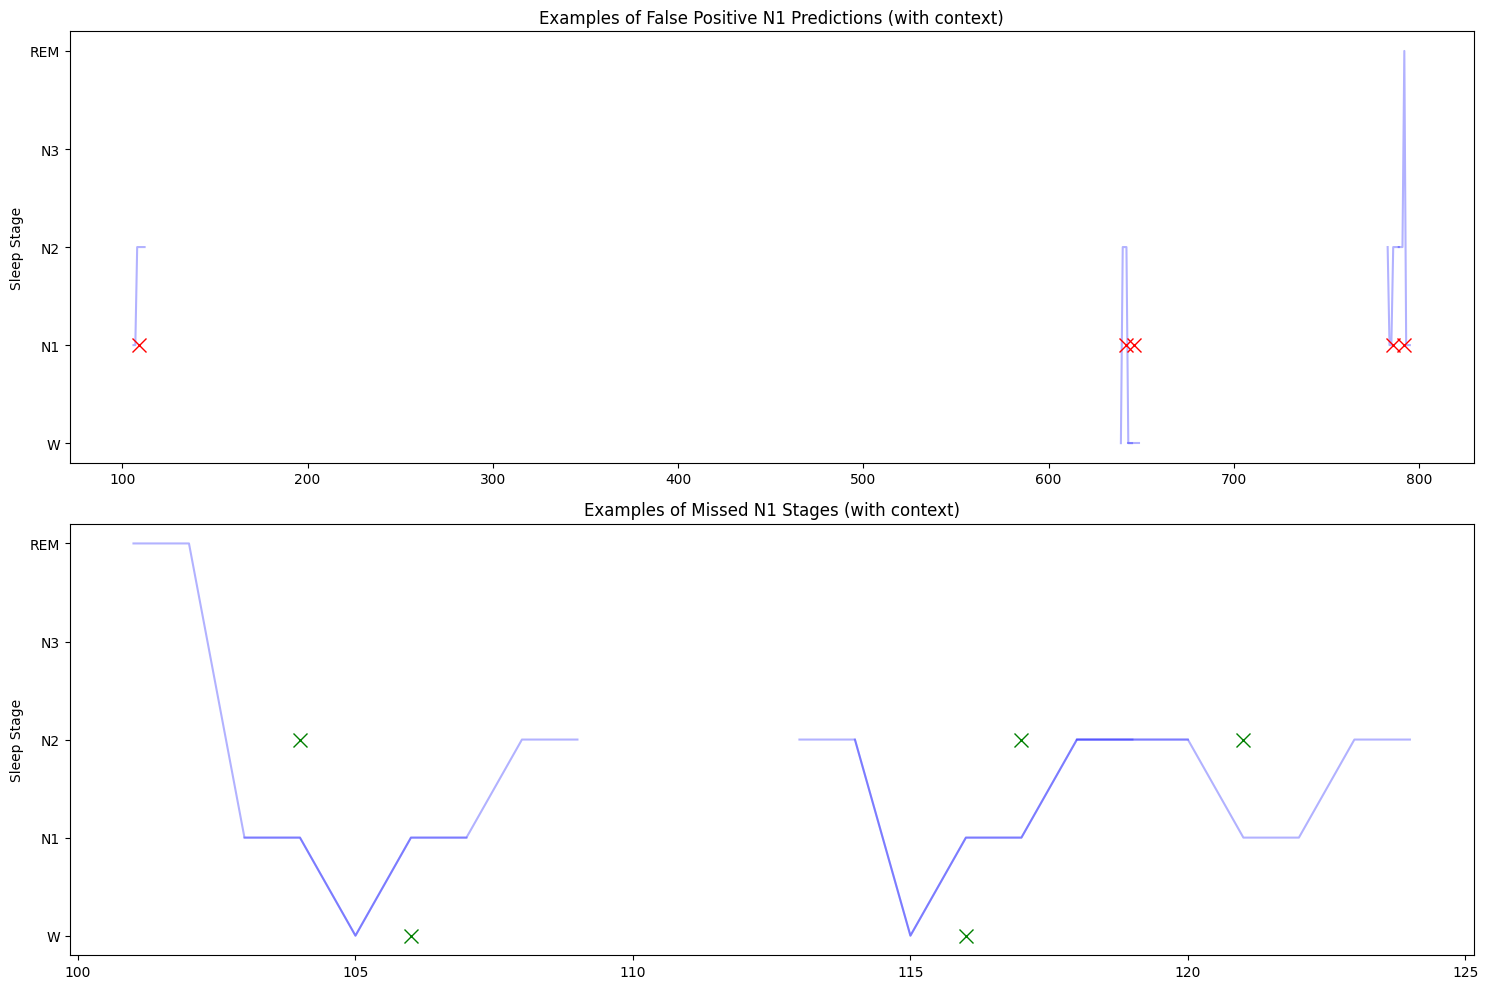

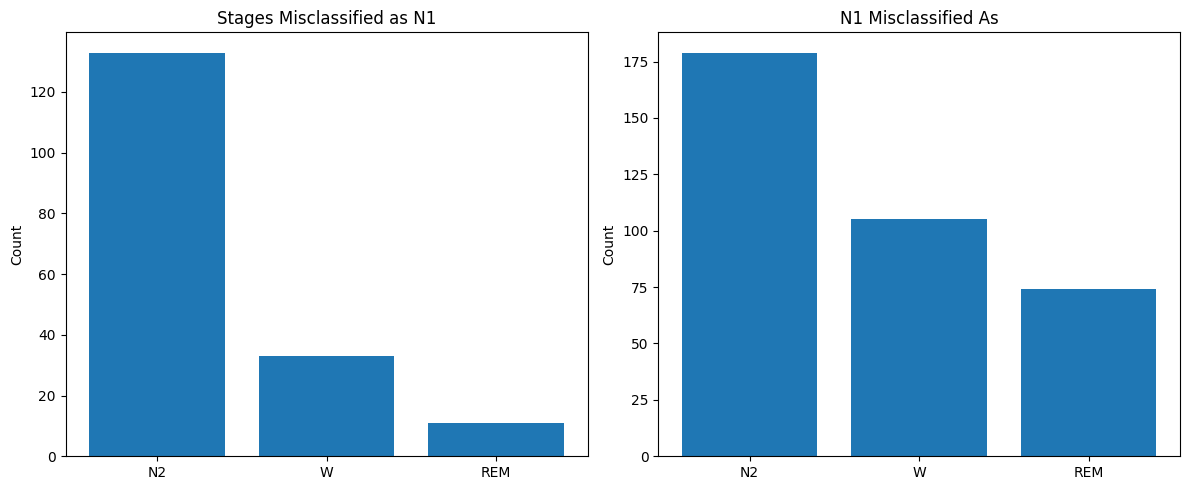

In [39]:
def analyze_n1_misclassifications(true_labels, predicted_labels):
    """
    Analyze where N1 misclassifications occur
    
    Args:
        true_labels: ground truth labels
        predicted_labels: model predictions
    """
    # Create confusion matrix specifically for N1 errors
    n1_errors = {
        'false_positives': [],  # Where model predicted N1 but was wrong
        'false_negatives': [],  # Where model missed actual N1
        'context': 3  # Number of epochs to show before/after each error
    }
    
    # Find all misclassifications
    for i in range(len(true_labels)):
        if true_labels[i] == 1 and predicted_labels[i] != 1:  # Missed N1
            n1_errors['false_negatives'].append(i)
        elif true_labels[i] != 1 and predicted_labels[i] == 1:  # False N1
            n1_errors['false_positives'].append(i)
    
    # Print summary statistics
    print("N1 Misclassification Analysis:")
    print(f"Total N1 False Positives: {len(n1_errors['false_positives'])}")
    print(f"Total N1 False Negatives: {len(n1_errors['false_negatives'])}")
    
    # Create detailed error analysis
    stage_names = ["W", "N1", "N2", "N3", "REM"]
    
    # Analyze what N1 was confused with
    fp_confused_with = {}
    fn_confused_as = {}
    
    # False Positives - what was wrongly labeled as N1
    for idx in n1_errors['false_positives']:
        true_stage = stage_names[true_labels[idx]]
        fp_confused_with[true_stage] = fp_confused_with.get(true_stage, 0) + 1
    
    # False Negatives - what N1 was mislabeled as
    for idx in n1_errors['false_negatives']:
        pred_stage = stage_names[predicted_labels[idx]]
        fn_confused_as[pred_stage] = fn_confused_as.get(pred_stage, 0) + 1
    
    # Print confusion details
    print("\nFalse Positives - Actually was:")
    for stage, count in fp_confused_with.items():
        print(f"{stage}: {count} times")
    
    print("\nFalse Negatives - Predicted as:")
    for stage, count in fn_confused_as.items():
        print(f"{stage}: {count} times")
    
    # Visualize the errors
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Context around False Positives
    plt.subplot(2, 1, 1)
    for error_idx in n1_errors['false_positives'][:5]:  # Show first 5 examples
        start_idx = max(0, error_idx - n1_errors['context'])
        end_idx = min(len(true_labels), error_idx + n1_errors['context'] + 1)
        
        plt.plot(range(start_idx, end_idx), 
                true_labels[start_idx:end_idx], 
                'b-', alpha=0.3)
        plt.plot(error_idx, predicted_labels[error_idx], 
                'rx', markersize=10, label='False Positive')
    
    plt.title('Examples of False Positive N1 Predictions (with context)')
    plt.ylabel('Sleep Stage')
    plt.yticks(range(5), stage_names)
    
    # Plot 2: Context around False Negatives
    plt.subplot(2, 1, 2)
    for error_idx in n1_errors['false_negatives'][:5]:  # Show first 5 examples
        start_idx = max(0, error_idx - n1_errors['context'])
        end_idx = min(len(true_labels), error_idx + n1_errors['context'] + 1)
        
        plt.plot(range(start_idx, end_idx), 
                true_labels[start_idx:end_idx], 
                'b-', alpha=0.3)
        plt.plot(error_idx, predicted_labels[error_idx], 
                'gx', markersize=10, label='False Negative')
    
    plt.title('Examples of Missed N1 Stages (with context)')
    plt.ylabel('Sleep Stage')
    plt.yticks(range(5), stage_names)
    
    plt.tight_layout()
    plt.show()
    
    # Plot confusion patterns
    plt.figure(figsize=(12, 5))
    
    # Plot 3: Distribution of stages misclassified as N1
    plt.subplot(1, 2, 1)
    stages = list(fp_confused_with.keys())
    counts = list(fp_confused_with.values())
    plt.bar(stages, counts)
    plt.title('Stages Misclassified as N1')
    plt.ylabel('Count')
    
    # Plot 4: Distribution of what N1 was misclassified as
    plt.subplot(1, 2, 2)
    stages = list(fn_confused_as.keys())
    counts = list(fn_confused_as.values())
    plt.bar(stages, counts)
    plt.title('N1 Misclassified As')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    return n1_errors

# Run the analysis
n1_errors = analyze_n1_misclassifications(val_labels, val_preds)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Original N1 Performance:
Precision: 0.5507
Recall: 0.4946
F1: 0.5212

HMM-smoothed N1 Performance:
Precision: 0.4009
Recall: 0.6214
F1: 0.4874

Full Classification Report:
              precision    recall  f1-score   support

           W       0.99      0.99      0.99     10236
          N1       0.40      0.62      0.49       560
          N2       0.73      0.74      0.73      1897
          N3       0.00      0.00      0.00       446
         REM       0.81      0.94      0.87       881

    accuracy                           0.90     14020
   macro avg       0.59      0.66      0.62     14020
weighted avg       0.89      0.90      0.89     14020



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

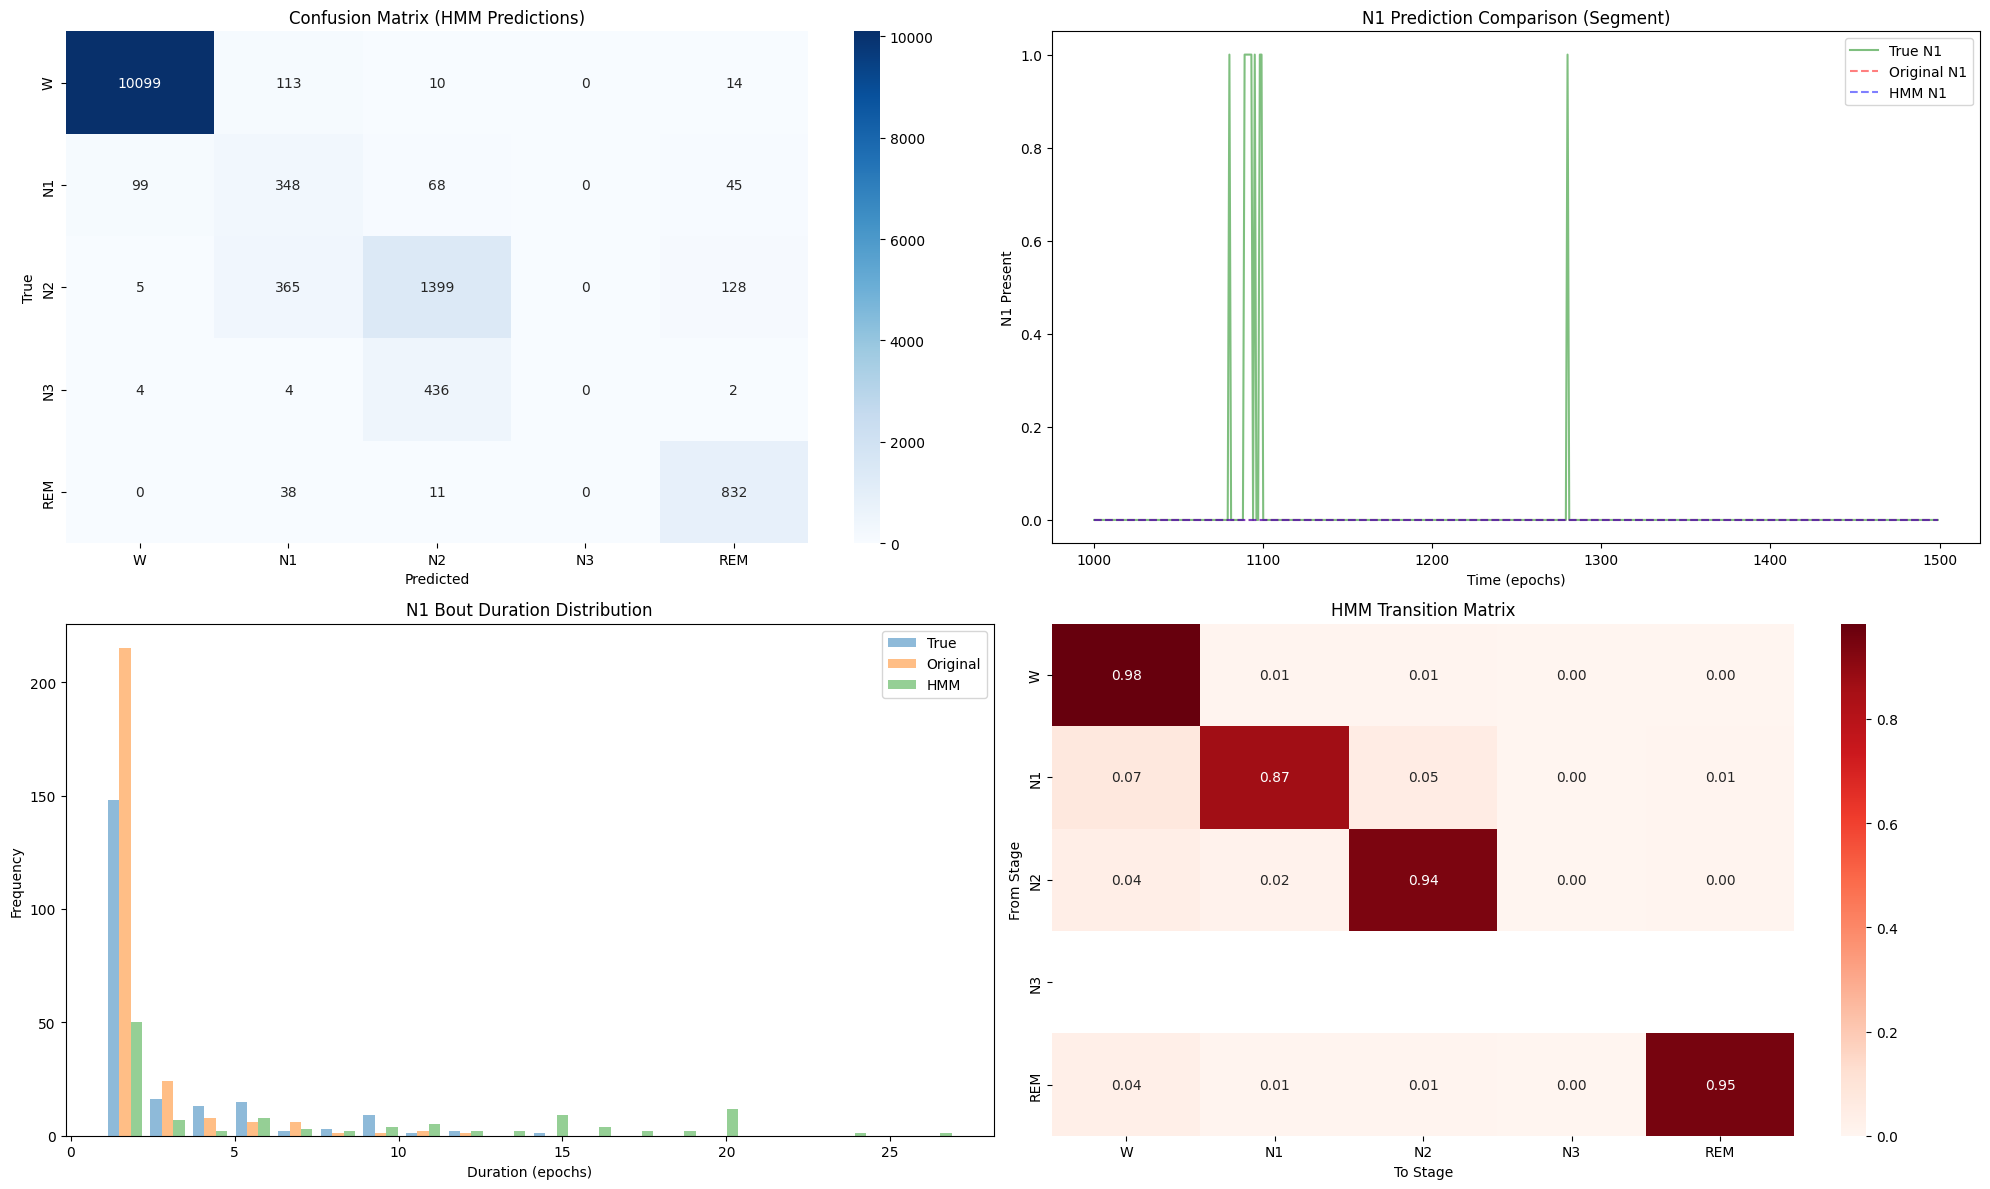


N1 Transition Analysis:

Transitions FROM N1 to:
W: 65
N1: 752
N2: 45
N3: 0
REM: 6

Transitions TO N1 from:
W: 78
N1: 752
N2: 32
N3: 0
REM: 6


In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from hmmlearn import hmm

def evaluate_hmm_results(val_labels, val_preds, hmm_preds, val_probs):
    """
    Evaluate and visualize HMM results with detailed N1 analysis
    """
    # 1. Print Performance Metrics
    print("Original N1 Performance:")
    original_n1_precision = precision_score(val_labels == 1, val_preds == 1)
    original_n1_recall = recall_score(val_labels == 1, val_preds == 1)
    original_n1_f1 = f1_score(val_labels == 1, val_preds == 1)
    
    print(f"Precision: {original_n1_precision:.4f}")
    print(f"Recall: {original_n1_recall:.4f}")
    print(f"F1: {original_n1_f1:.4f}")
    
    print("\nHMM-smoothed N1 Performance:")
    hmm_n1_precision = precision_score(val_labels == 1, hmm_preds == 1)
    hmm_n1_recall = recall_score(val_labels == 1, hmm_preds == 1)
    hmm_n1_f1 = f1_score(val_labels == 1, hmm_preds == 1)
    
    print(f"Precision: {hmm_n1_precision:.4f}")
    print(f"Recall: {hmm_n1_recall:.4f}")
    print(f"F1: {hmm_n1_f1:.4f}")
    
    # 2. Print Full Classification Report
    print("\nFull Classification Report:")
    print(classification_report(val_labels, hmm_preds, 
                              target_names=["W","N1","N2","N3","REM"]))
    
    # 3. Visualizations
    plt.figure(figsize=(20, 12))
    
    # Plot 1: Confusion Matrix
    plt.subplot(2, 2, 1)
    cm = confusion_matrix(val_labels, hmm_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["W","N1","N2","N3","REM"],
                yticklabels=["W","N1","N2","N3","REM"])
    plt.title('Confusion Matrix (HMM Predictions)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Plot 2: N1 Prediction Comparison
    plt.subplot(2, 2, 2)
    # Show a segment of predictions for clarity
    segment_size = 500
    segment_start = 1000  # Start from a non-zero point to see interesting patterns
    plt.plot(range(segment_start, segment_start+segment_size), 
            val_labels[segment_start:segment_start+segment_size] == 1, 
            'g-', label='True N1', alpha=0.5)
    plt.plot(range(segment_start, segment_start+segment_size), 
            val_preds[segment_start:segment_start+segment_size] == 1, 
            'r--', label='Original N1', alpha=0.5)
    plt.plot(range(segment_start, segment_start+segment_size), 
            hmm_preds[segment_start:segment_start+segment_size] == 1, 
            'b--', label='HMM N1', alpha=0.5)
    plt.title('N1 Prediction Comparison (Segment)')
    plt.legend()
    plt.xlabel('Time (epochs)')
    plt.ylabel('N1 Present')
    
    # Plot 3: N1 Duration Distribution
    plt.subplot(2, 2, 3)
    
    def get_bout_lengths(predictions, stage=1):
        bouts = []
        current_bout = 0
        for pred in predictions:
            if pred == stage:
                current_bout += 1
            elif current_bout > 0:
                bouts.append(current_bout)
                current_bout = 0
        if current_bout > 0:
            bouts.append(current_bout)
        return bouts
    
    true_bouts = get_bout_lengths(val_labels)
    orig_bouts = get_bout_lengths(val_preds)
    hmm_bouts = get_bout_lengths(hmm_preds)
    
    plt.hist([true_bouts, orig_bouts, hmm_bouts], 
             label=['True', 'Original', 'HMM'],
             bins=20, alpha=0.5)
    plt.title('N1 Bout Duration Distribution')
    plt.xlabel('Duration (epochs)')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Plot 4: Transition Matrix
    plt.subplot(2, 2, 4)
    transition_matrix = np.zeros((5, 5))
    for i in range(len(hmm_preds)-1):
        transition_matrix[hmm_preds[i], hmm_preds[i+1]] += 1
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(transition_matrix, annot=True, fmt='.2f', cmap='Reds',
                xticklabels=["W","N1","N2","N3","REM"],
                yticklabels=["W","N1","N2","N3","REM"])
    plt.title('HMM Transition Matrix')
    plt.xlabel('To Stage')
    plt.ylabel('From Stage')
    
    plt.tight_layout()
    plt.show()
    
    # Additional N1-specific analysis
    print("\nN1 Transition Analysis:")
    n1_transitions_to = {stage: 0 for stage in ["W","N1","N2","N3","REM"]}
    n1_transitions_from = {stage: 0 for stage in ["W","N1","N2","N3","REM"]}
    
    for i in range(len(hmm_preds)-1):
        if hmm_preds[i] == 1:  # If current is N1
            n1_transitions_to[["W","N1","N2","N3","REM"][hmm_preds[i+1]]] += 1
        if hmm_preds[i+1] == 1:  # If next is N1
            n1_transitions_from[["W","N1","N2","N3","REM"][hmm_preds[i]]] += 1
    
    print("\nTransitions FROM N1 to:")
    for stage, count in n1_transitions_to.items():
        print(f"{stage}: {count}")
    
    print("\nTransitions TO N1 from:")
    for stage, count in n1_transitions_from.items():
        print(f"{stage}: {count}")
    
    return hmm_preds

# Run the analysis with visualizations
model, transition_matrix = create_sleep_hmm(val_labels, val_preds, val_probs)
hmm_predictions = apply_hmm_smoothing(val_preds, val_probs, transition_matrix)
final_predictions = evaluate_hmm_results(val_labels, val_preds, hmm_predictions, val_probs)